In [1]:
from typing import Union
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import sys
import time
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)
import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

from scipy import stats
import pingouin

import matplotlib.pyplot as plt
import seaborn as sns

import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


In [3]:
def anova_eta2(ydata, ylabels):
    """ydata = (nsample, nvariable)
    ylabel = (nsample,)
    """
    gmean = ydata.mean(axis=0)

    SSt = np.power((ydata-gmean), 2).sum(axis=0)
    SSb = np.zeros(ydata.shape[1])

    clsts = np.unique(ylabels)
    # Yclsts = []
    for clst in clsts:
        cond = ylabels==clst
        yclst = ydata[cond]
        lmean = yclst.mean(axis=0)
        ln = len(yclst)

        # for each gene
        SSb += np.power((lmean-gmean), 2)*ln

    # get eta2
    assert np.all(SSb<=SSt)
    eta2 = SSb/(SSt+1e-6)
    return eta2, SSt, SSb

# file paths and load data

In [4]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
# scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_10x_ctxhippo_a_DPNMF_matrix.h5ad'

scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

# DPNMF matrix 
pmat_path = f'{dat_dir}dpnmf.csv' 


In [5]:
%%time
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)
ref_data_genes = anndata.read_h5ad(scrna_genes_path) # library size normed (no log)

CPU times: user 650 ms, sys: 1.39 s, total: 2.04 s
Wall time: 2.04 s


In [6]:
pmat = pd.read_csv(pmat_path, index_col=0).loc[ref_data_genes.var.index]
pmatf = (pmat/pmat.sum(axis=0))
print(pmat.shape)
print(pmatf.shape)
pmat_maxw = pmat.max(axis=1)
pmatf_maxw = pmatf.max(axis=1)

(5576, 24)
(5576, 24)


In [7]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      
X_refdata = np.array(ref_data.X)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']


In [8]:
# ref_data.obs.groupby('Level_1_class_label').size()
print(ref_data)
print(ref_data_genes)

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

# Run gene reconstruction
- find neighbors using 24 bits
- reconstruct genes in high-dimensions based on those neighbors

- what gene set to use: 5818 genes involved (5576 overlap with scRNA SS)

In [9]:
%%time
# randomly split cells into train (lowdim, highdim) and test (lowdim, highdim to be predicted)
X = ref_data.X.copy()
yraw = np.array(ref_data_genes.X.todense()).copy()

X = basicu.zscore(X, axis=0)
y = np.log10(yraw+1)
# y.data = np.log10(y.data+1)

print(X.shape, y.shape)

(73347, 24) (73347, 5576)
CPU times: user 7.42 s, sys: 2.09 s, total: 9.51 s
Wall time: 9.51 s


# clusterings

In [10]:
# adata = anndata.AnnData(X=y, obs=ref_data.obs)
# sc.tl.pca(adata, svd_solver='arpack') # with or without PCs
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

In [11]:
# # resolutions = [1, 10, 100]#, 1000, 10000]
# # resolutions = [1000, 10000]
# # resolutions = [200, 500, 2000, 5000]
# resolutions = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

# adata.uns['resolutions'] = np.array(resolutions)

# for r in tqdm.tqdm(resolutions):
#     col = f'leiden_r{r}'
#     sc.tl.leiden(adata, resolution=r, key_added=col)
#     eta2, SSt, SSb = anova_eta2(y, adata.obs[col].values)
#     adata.var[f'eta2_{col}'] = eta2
#     adata.var[f'SSt_{col}'] = SSt
#     adata.var[f'SSb_{col}'] = SSb 
    
#     nclst = len(np.unique(adata.obs[col].values))
#     print(r, nclst)
    
#     # break

In [12]:
# %%time
# # save results (adata res)
# output = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_eta2.h5ad'
# adata.write(output)

In [13]:
# # eta results -- used below; naming is bad for historical reasons
# eta2_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_eta2.h5ad'
# adata = anndata.read_h5ad(eta2_path)
# adata

# PCA

In [14]:
def shuffle_cols_per_row(mat):
    """
    """
    m, n = mat.shape
    mat_shff = np.empty(mat.shape)
    for i in np.arange(len(mat)):
        mat_shff[i] = mat[i][np.random.choice(n, size=n, replace=False)]
        
    return mat_shff

In [15]:
y.shape

(73347, 5576)

In [16]:
ncutoff = 200
ncell, ngene = y.shape

In [17]:
%%time
np.random.seed(0)

ti = time.time()

pca = PCA(n_components=ncutoff)
us = pca.fit_transform(y)
vt = pca.components_
varr = pca.explained_variance_ratio_

# save
f = os.path.join(res_dir, 'smartseq_pca_us_5576_genes_May10.npy')
print(f)
np.save(f, us)
f = os.path.join(res_dir, 'smartseq_pca_vt_5576_genes_May10.npy')
print(f)
np.save(f, vt)
f = os.path.join(res_dir, 'smartseq_pca_varr_5576_genes_May10.npy')
print(f)
np.save(f, varr)
print(time.time()-ti)

/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/smartseq_pca_us_5576_genes_May10.npy
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/smartseq_pca_vt_5576_genes_May10.npy
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/smartseq_pca_varr_5576_genes_May10.npy
14.077711343765259
CPU times: user 4min 58s, sys: 10.5 s, total: 5min 8s
Wall time: 14.1 s


In [18]:
ti = time.time()

# shuffle gene for each cell
y_shffg = shuffle_cols_per_row(y)
pca_shffg = PCA(n_components=ncutoff)
us_shffg = pca_shffg.fit_transform(y_shffg)
vt_shffg = pca_shffg.components_
varr_shffg = pca_shffg.explained_variance_ratio_

# save
f = os.path.join(res_dir, 'smartseq_pca_us_shuff_genes_May10.npy')
print(f)
np.save(f, us_shffg)
f = os.path.join(res_dir, 'smartseq_pca_vt_shuff_genes_May10.npy')
print(f)
np.save(f, vt_shffg)
f = os.path.join(res_dir, 'smartseq_pca_varr_shuff_genes_May10.npy')
print(f)
np.save(f, varr_shffg)
print(time.time()-ti)

/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/smartseq_pca_us_shuff_genes_May10.npy
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/smartseq_pca_vt_shuff_genes_May10.npy
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/smartseq_pca_varr_shuff_genes_May10.npy
32.896358013153076


In [19]:
ti = time.time()

# shuffle cell for each gene
y_shffc = shuffle_cols_per_row(y.T).T
pca_shffc = PCA(n_components=ncutoff)
us_shffc = pca_shffc.fit_transform(y_shffc)
vt_shffc = pca_shffc.components_
varr_shffc = pca_shffc.explained_variance_ratio_

# save
f = os.path.join(res_dir, 'smartseq_pca_us_shuff_cells_May10.npy')
print(f)
np.save(f, us_shffc)
f = os.path.join(res_dir, 'smartseq_pca_vt_shuff_cells_May10.npy')
print(f)
np.save(f, vt_shffc)
f = os.path.join(res_dir, 'smartseq_pca_varr_shuff_cells_May10.npy')
print(f)
np.save(f, varr_shffc)
print(time.time()-ti)

/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/smartseq_pca_us_shuff_cells_May10.npy
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/smartseq_pca_vt_shuff_cells_May10.npy
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/smartseq_pca_varr_shuff_cells_May10.npy
36.56713938713074


In [20]:
# load in 
f = os.path.join(res_dir, 'smartseq_pca_varr_5576_genes_May10.npy')
varr = np.load(f, allow_pickle=True)
f = os.path.join(res_dir, 'smartseq_pca_varr_shuff_genes_May10.npy')
varr_shffg = np.load(f, allow_pickle=True)
f = os.path.join(res_dir, 'smartseq_pca_varr_shuff_cells_May10.npy')
varr_shffc = np.load(f, allow_pickle=True)

# 
f = os.path.join(res_dir, 'smartseq_pca_us_5576_genes_May10.npy')
us = np.load(f, allow_pickle=True)
f = os.path.join(res_dir, 'smartseq_pca_us_shuff_genes_May10.npy')
us_shffg = np.load(f, allow_pickle=True)
f = os.path.join(res_dir, 'smartseq_pca_us_shuff_cells_May10.npy')
us_shffc = np.load(f, allow_pickle=True)
print(us.shape, us_shffg.shape, us_shffc.shape)

(73347, 200) (73347, 200) (73347, 200)


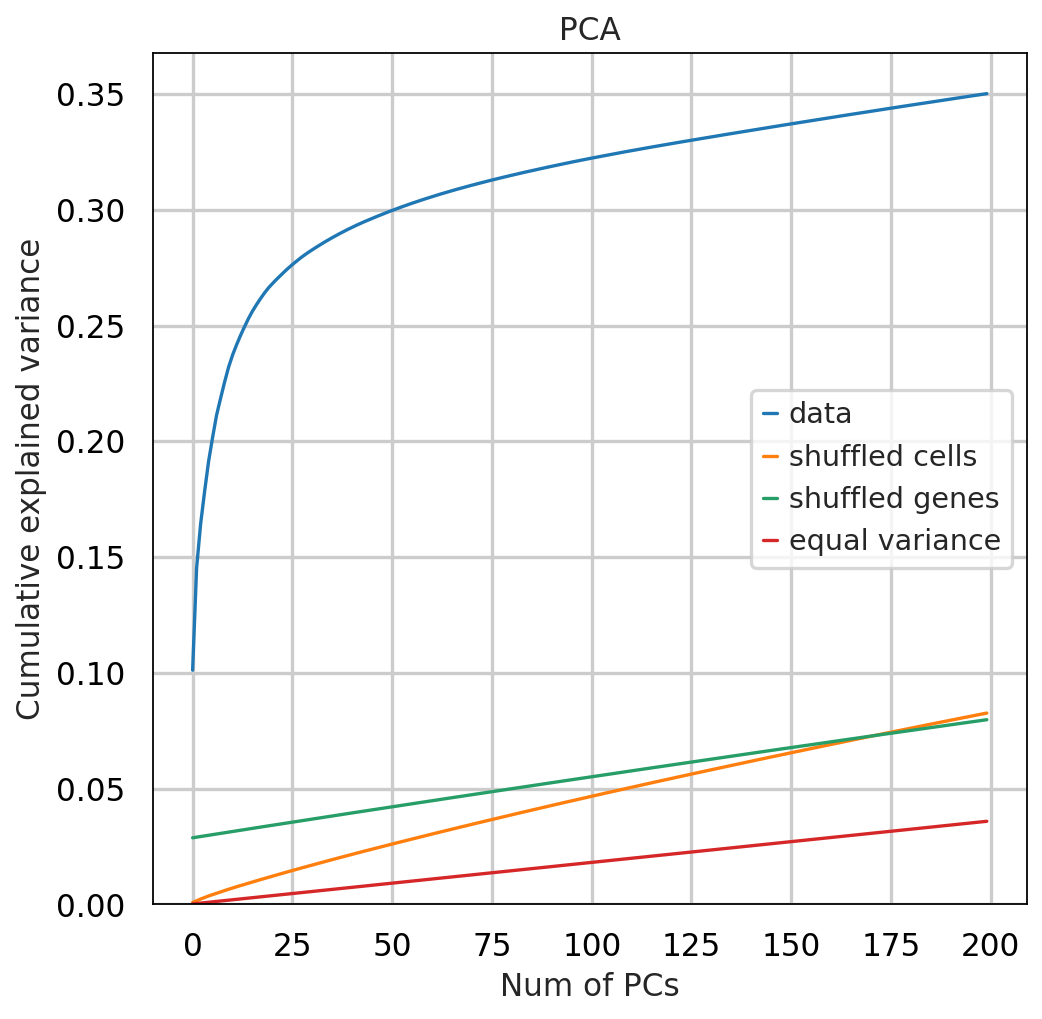

In [55]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(varr), '-', label='data')
ax.plot(np.cumsum(varr_shffc), '-', label='shuffled cells')
ax.plot(np.cumsum(varr_shffg), '-', label='shuffled genes')
ax.plot(np.cumsum([1/ngene]*ngene)[:ncutoff], '-', label='equal variance')
ax.set_ylim(ymin=0)
ax.set_ylabel('Cumulative explained variance')
ax.set_xlabel('Num of PCs')
ax.set_title('PCA')
ax.legend()
plt.show()

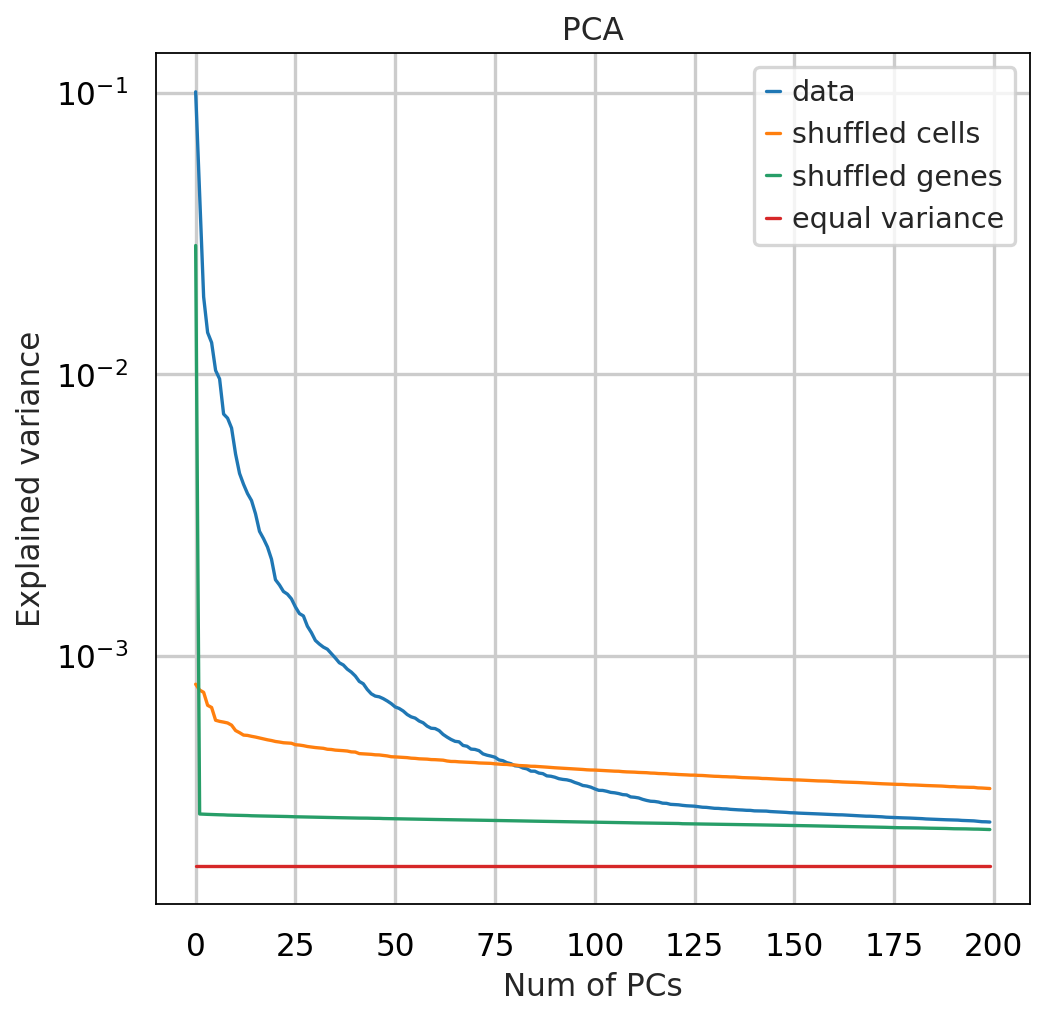

In [56]:
fig, ax = plt.subplots()
ax.plot(varr, '-', label='data')
ax.plot(varr_shffc, '-', label='shuffled cells')
ax.plot(varr_shffg, '-', label='shuffled genes')
ax.plot(np.array([1/ngene]*ngene)[:ncutoff], '-', label='equal variance')
# ax.set_ylim(ymin=0)
ax.set_yscale('log')
ax.set_xlabel('Num of PCs')
ax.set_ylabel('Explained variance')
ax.set_title('PCA')
ax.legend()
plt.show()

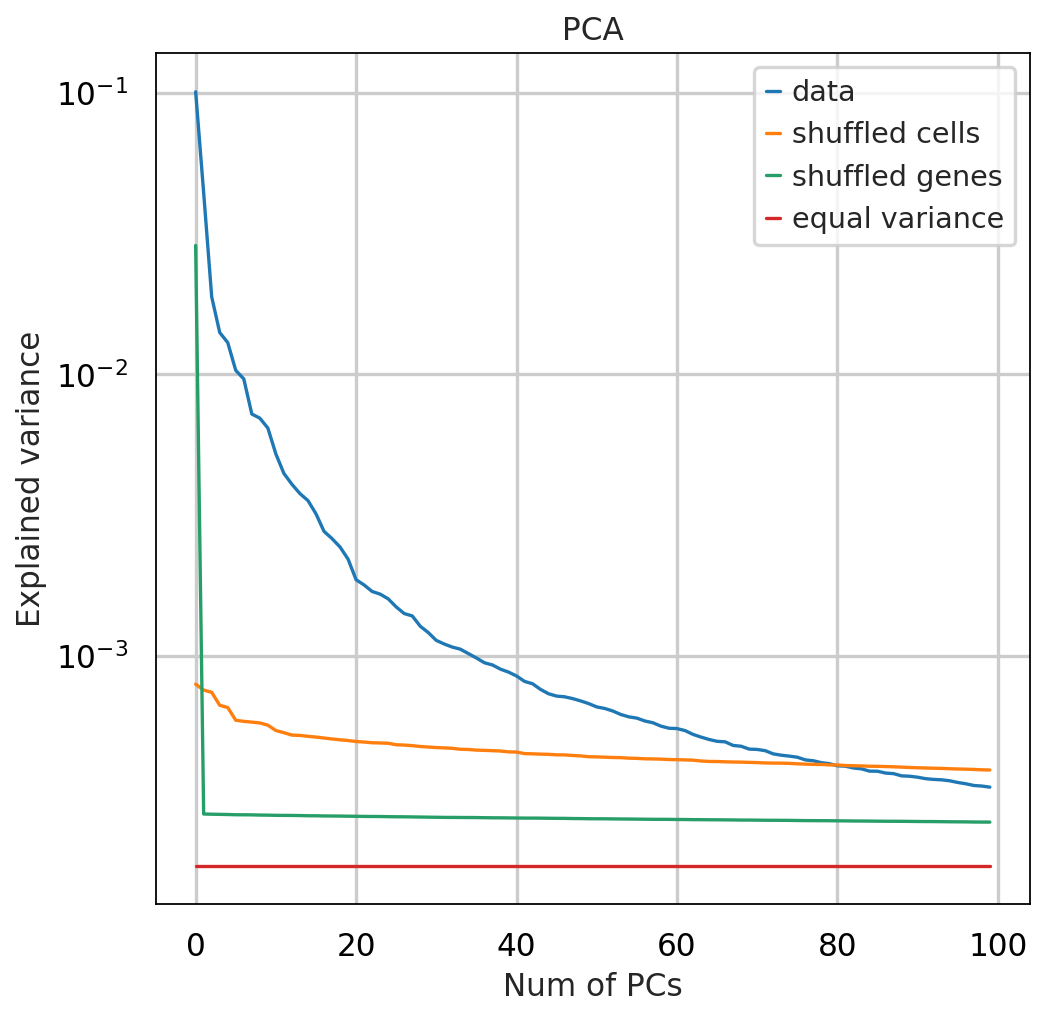

In [57]:
ncutoff_viz = 100

fig, ax = plt.subplots()
ax.plot(varr[:ncutoff_viz], '-', label='data')
ax.plot(varr_shffc[:ncutoff_viz], '-', label='shuffled cells')
ax.plot(varr_shffg[:ncutoff_viz], '-', label='shuffled genes')
ax.plot(np.array([1/ngene]*ngene)[:ncutoff_viz], '-', label='equal variance')

# ax.set_ylim(ymin=0)
ax.set_yscale('log')
ax.set_xlabel('Num of PCs')
ax.set_ylabel('Explained variance')
ax.set_title('PCA')
ax.legend()
plt.show()

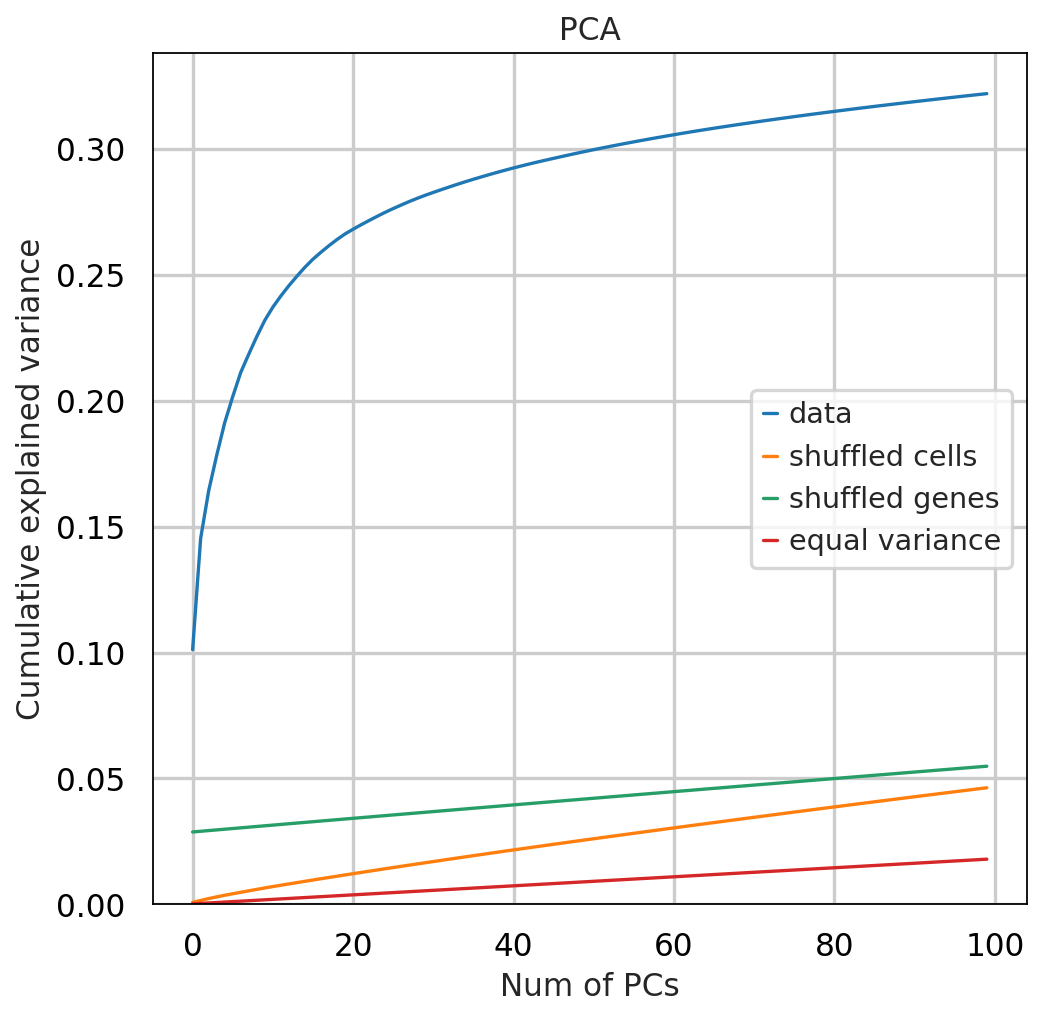

In [58]:
ncutoff_viz = 100

fig, ax = plt.subplots()
ax.plot(np.cumsum(varr)[:ncutoff_viz], '-', label='data')
ax.plot(np.cumsum(varr_shffc)[:ncutoff_viz], '-', label='shuffled cells')
ax.plot(np.cumsum(varr_shffg)[:ncutoff_viz], '-', label='shuffled genes')
ax.plot(np.cumsum([1/ngene]*ngene)[:ncutoff_viz], '-', label='equal variance')
ax.set_ylim(ymin=0)
ax.set_ylabel('Cumulative explained variance')
ax.set_xlabel('Num of PCs')
ax.set_title('PCA')
ax.legend()
plt.show()

In [59]:
# 80 PCs
npc1 = 80
npc2 = 200

varr[:npc1].sum(), varr[:npc2].sum()

(0.3145189255914189, 0.35014831274569436)

/tmp/ipykernel_85891/4033203049.py:4: RuntimeWarning:

invalid value encountered in true_divide

/tmp/ipykernel_85891/4033203049.py:8: RuntimeWarning:

invalid value encountered in true_divide



<AxesSubplot:>

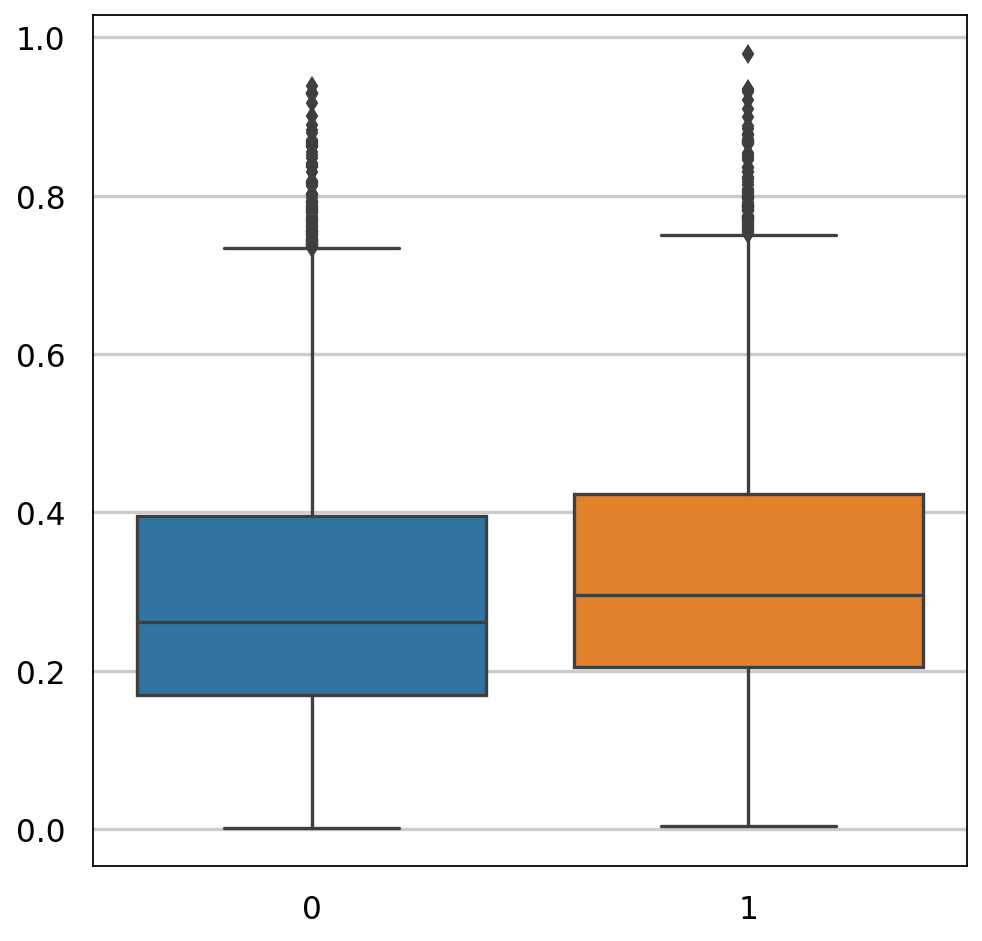

In [60]:
ycentered = y-np.mean(y, axis=0)

yhat = us[:,:npc1].dot(vt[:npc1,:])
varexp1 = 1-(np.power(np.linalg.norm(ycentered-yhat, ord=2, axis=0), 2)/
          np.power(np.linalg.norm(ycentered, ord=2, axis=0), 2)
         )
yhat = us[:,:npc2].dot(vt[:npc2,:])
varexp2 = 1-(np.power(np.linalg.norm(ycentered-yhat, ord=2, axis=0), 2)/
          np.power(np.linalg.norm(ycentered, ord=2, axis=0), 2)
         )

sns.boxplot(data=np.vstack([varexp1, varexp2]).T)

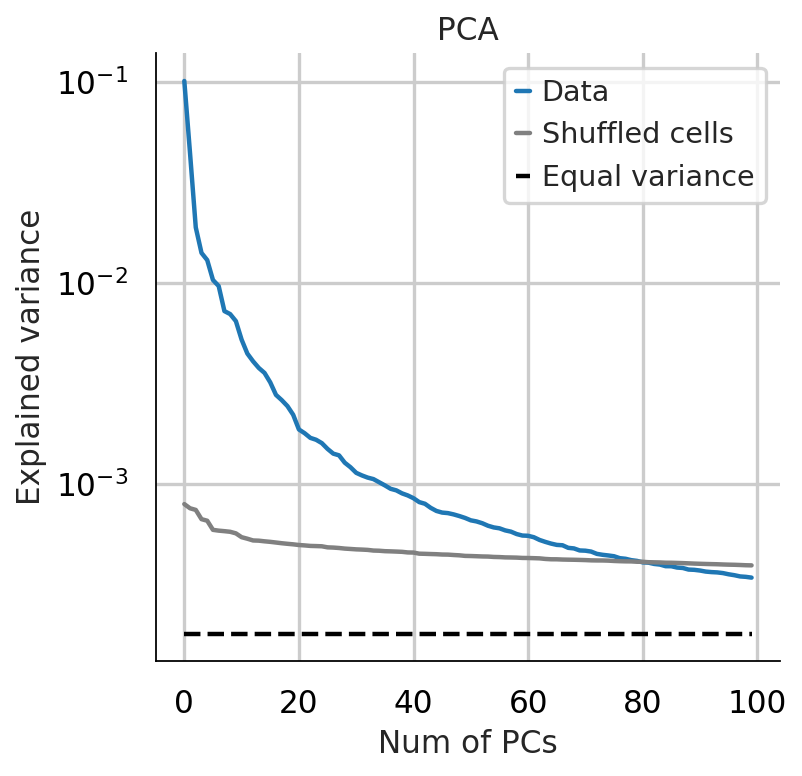

In [61]:
ncutoff_viz = 100

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(varr[:ncutoff_viz], '-', label='Data', linewidth=2)
ax.plot(varr_shffc[:ncutoff_viz], '-', color='gray', label='Shuffled cells', linewidth=2)
# ax.plot(varr_shffg[:ncutoff_viz], '-', label='shuffled genes')
ax.plot(np.array([1/ngene]*ngene)[:ncutoff_viz], '--k', label='Equal variance', linewidth=2)
sns.despine(ax=ax)

# ax.set_ylim(ymin=0)
# ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Num of PCs')
ax.set_ylabel('Explained variance')
ax.set_title('PCA')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

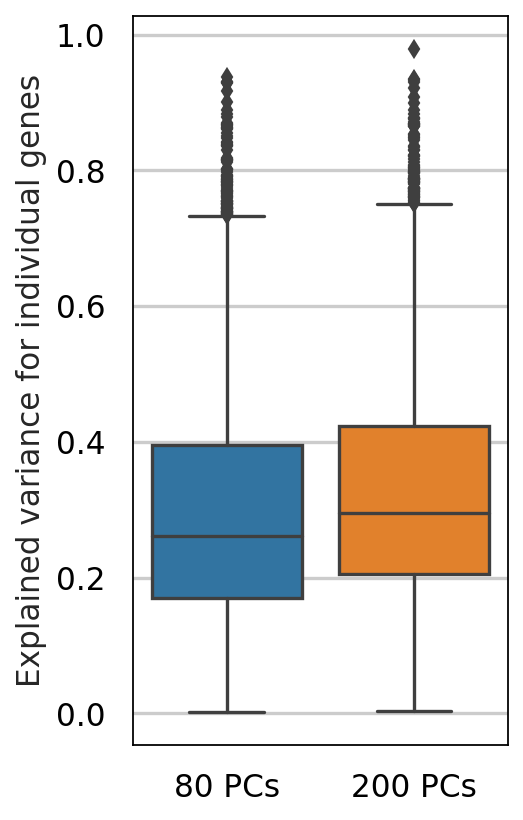

In [62]:
fig, ax = plt.subplots(figsize=(3,6))
sns.boxplot(data=pd.DataFrame(np.vstack([varexp1, varexp2]).T, 
                              columns=[f'{npc1} PCs', f'{npc2} PCs']), 
            ax=ax)
ax.set_ylabel('Explained variance for individual genes')
plt.show()